This notebook follows along the Sagemaker/Spark tutorial found [here](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-spark/pyspark_mnist/pyspark_mnist_pca_kmeans.ipynb).

# Import

## Packages / Libraries

In [18]:
import os
import boto3
import numpy as np
import string

import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark

from pyspark import SparkContext, SparkConf
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession

from sagemaker_pyspark.algorithms import PCASageMakerEstimator, KMeansSageMakerEstimator
from sagemaker_pyspark import RandomNamePolicyFactory, IAMRole, EndpointCreationPolicy
from sagemaker_pyspark.transformation.serializers import ProtobufRequestRowSerializer
from sagemaker_pyspark import SageMakerModel
from sagemaker_pyspark import SageMakerResourceCleanup

from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt

## Setup AWS and Spark

In [3]:
role = get_execution_role()
region = boto3.Session().region_name

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# See the SageMaker Spark Github to learn how to connect to EMR from a notebook instance
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
    .master("local[*]").getOrCreate()
    
spark

## Load Data

In [6]:
spark._jsc.hadoopConfiguration().set('fs.s3a.endpoint', 's3.{}.amazonaws.com'.format(region))

trainingData = spark.read.format('libsvm')\
    .option('numFeatures', '784')\
    .load('s3a://sagemaker-sample-data-{}/spark/mnist/train/'.format(region))

testData = spark.read.format('libsvm')\
    .option('numFeatures', '784')\
    .load('s3a://sagemaker-sample-data-{}/spark/mnist/test/'.format(region))

trainingData.show(5)
trainingData.printSchema()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  5.0|(784,[152,153,154...|
|  0.0|(784,[127,128,129...|
|  4.0|(784,[160,161,162...|
|  1.0|(784,[158,159,160...|
|  9.0|(784,[208,209,210...|
+-----+--------------------+
only showing top 5 rows

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



# Set-up Model
This notebook with first perform dimension reduction via PCA followed by cluster analysis with K-means. We will use a python Pipeline to join these two processses.

For PCA we will reduce the data dimensions to 50 features. This is an arbitrary value for purpose of this example. In a real life situation, I would need to evaluate the information lost during the PCA to determine an acceptable feature set size.

For K-Means, the cluster size is arbitrarily set to 10. For K-Means clustering I would usually use the elbow method or silhouette score (my preference, with silhouette plots). This post here has a good walkthrough for how to determine the optimal number of clusters: [https://runawayhorse001.github.io/LearningApacheSpark/clustering.html](https://runawayhorse001.github.io/LearningApacheSpark/clustering.html)

## PCA

In [7]:
pcaSageMakerEstimator = PCASageMakerEstimator(
  sagemakerRole = IAMRole(role),
  trainingInstanceType = "ml.m4.xlarge",
  trainingInstanceCount = 1,
  endpointInstanceType = "ml.t2.large",
  endpointInitialInstanceCount = 1,
  namePolicyFactory=RandomNamePolicyFactory("sparksm-3p-")
)

In [8]:
# Set parameters for PCA (number of features in input and the number of principal components to find)
pcaSageMakerEstimator.setFeatureDim(784)
pcaSageMakerEstimator.setNumComponents(50)

## K-Means

In [9]:
# 2nd stage: K-Means on SageMaker
kMeansSageMakerEstimator = KMeansSageMakerEstimator(
  sagemakerRole = IAMRole(role),
  trainingSparkDataFormatOptions = {"featuresColumnName": "projection"}, # Default output column generated by PCASageMakerEstimator
  requestRowSerializer = ProtobufRequestRowSerializer(featuresColumnName = "projection"), # Default output column generated by PCASageMakerEstimator
  trainingInstanceType = "ml.m4.xlarge",
  trainingInstanceCount = 1,
  endpointInstanceType = "ml.t2.large",
  endpointInitialInstanceCount = 1,
  namePolicyFactory=RandomNamePolicyFactory("sparksm-3k-"),
  endpointCreationPolicy = EndpointCreationPolicy.CREATE_ON_TRANSFORM
)

In [10]:
# Set parameters for K-Means
kMeansSageMakerEstimator.setFeatureDim(50)
kMeansSageMakerEstimator.setK(10)

## Pipeline

In [11]:
pipelineSM = Pipeline(stages=[pcaSageMakerEstimator, kMeansSageMakerEstimator])

# Train
With the estimators and pipeline established, we can now train the data.

In [12]:
pipelineModelSM = pipelineSM.fit(trainingData)

# Evaluate

With a trained PCA estimator and K-Means model. we now need to evalute the pipeline performance with the test data. 

## Transform
First, we transform the test data to generate predicted clusters.

In [13]:
transformedData = pipelineModelSM.transform(testData)
transformedData.show()

+-----+--------------------+--------------------+-------------------+---------------+
|label|            features|          projection|distance_to_cluster|closest_cluster|
+-----+--------------------+--------------------+-------------------+---------------+
|  7.0|(784,[202,203,204...|[-115.06117248535...|   1331.52490234375|            1.0|
|  2.0|(784,[94,95,96,97...|[296.885986328125...| 1838.5159912109375|            2.0|
|  1.0|(784,[128,129,130...|[-48.367130279541...|  947.8922119140625|            7.0|
|  0.0|(784,[124,125,126...|[100.707977294921...|  1500.972412109375|            3.0|
|  4.0|(784,[150,151,159...|[-150.96253967285...|  1093.984130859375|            0.0|
|  1.0|(784,[156,157,158...|[-97.345962524414...| 1046.1939697265625|            5.0|
|  4.0|(784,[149,150,151...|[-94.274291992187...|  1468.630126953125|            6.0|
|  9.0|(784,[179,180,181...|[163.227905273437...| 1484.5330810546875|            6.0|
|  5.0|(784,[129,130,131...|[135.277954101562...|  181

In [14]:
transformedData.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- projection: vector (nullable = true)
 |-- distance_to_cluster: double (nullable = true)
 |-- closest_cluster: double (nullable = true)



## Inspect

In [15]:
# Helper function to display a digit
def showDigit(img, caption='', xlabel='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axes.get_xaxis().set_ticks([])
    subplot.axes.get_yaxis().set_ticks([])
    plt.title(caption)
    plt.xlabel(xlabel)
    subplot.imshow(imgr, cmap='gray')
    
def displayClusters(data):
    images = np.array(data.select("features").cache().take(250))
    clusters = data.select("closest_cluster").cache().take(250)

    for cluster in range(10):
        print('\n\n\nCluster {}:'.format(string.ascii_uppercase[cluster]))
        digits = [ img for l, img in zip(clusters, images) if int(l.closest_cluster) == cluster ]
        height=((len(digits)-1)//5)+1
        width=5
        plt.rcParams["figure.figsize"] = (width,height)
        _, subplots = plt.subplots(height, width)
        subplots=np.ndarray.flatten(subplots)
        for subplot, image in zip(subplots, digits):
            showDigit(image, subplot=subplot)
        for subplot in subplots[len(digits):]:
            subplot.axis('off')

        plt.show()




Cluster A:


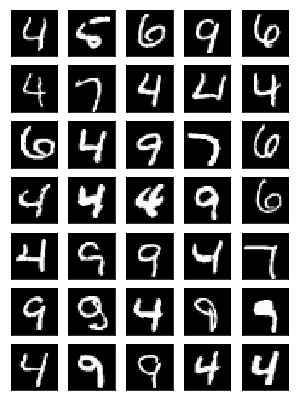




Cluster B:


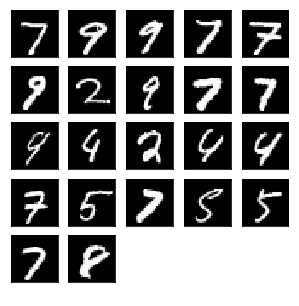




Cluster C:


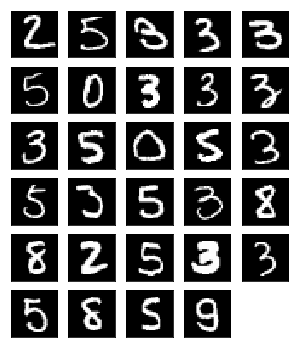




Cluster D:


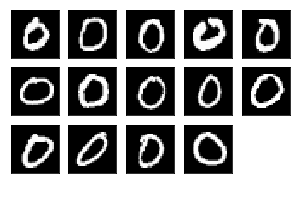




Cluster E:


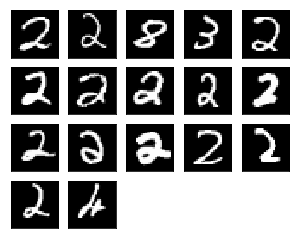




Cluster F:


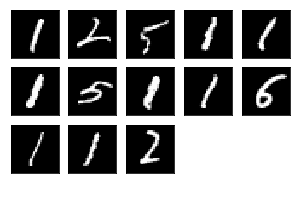




Cluster G:


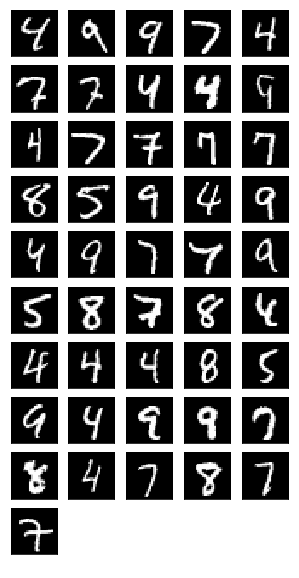




Cluster H:


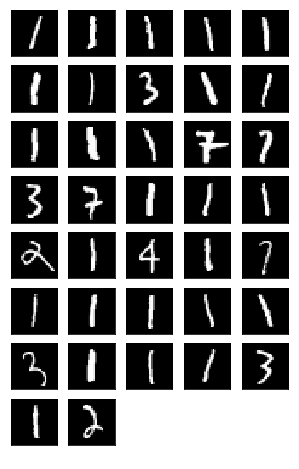




Cluster I:


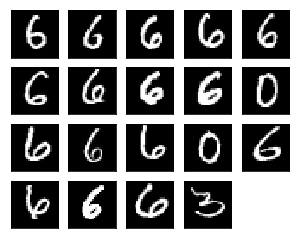




Cluster J:


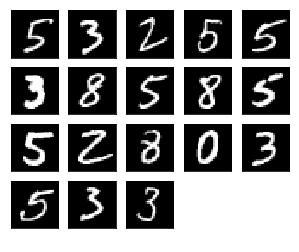

In [16]:
displayClusters(transformedData)

# Clean-Up
I do not want to be needlessly charged for deployed enpoints after this example is through, so I need to shut everything down.

In [19]:
def cleanUp(model):
    resource_cleanup = SageMakerResourceCleanup(model.sagemakerClient)
    resource_cleanup.deleteResources(model.getCreatedResources())
    
# Delete the SageMakerModel in pipeline
for m in pipelineModelSM.stages:
    if isinstance(m, SageMakerModel):
        cleanUp(m)